# Read SUMMA output

In [39]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph
import matplotlib.gridspec as gridspec
import string

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('paper', font_scale=1.5)
%matplotlib inline

In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'

dirProj = dirPre + 'SnowHydrology/proj/ModTsfc/'
dirPrint = dirProj + 'Graphics'
dirData = dirProj + 'data'

## Functions to quickly evaluate all model output

In [12]:
def evalBiasTs(ax, dsDict, obs, labels, ls, lcolor):
    # Tsurf scatter plot
    hours = np.arange(0, 24)
    for ex in sorted(dsDict.keys()):
        ax.plot(dsDict[ex].scalarSurfaceTemp - 273.15, obs.Tsrf, '.',
                label=labels[ex],
                color=lcolor[ex])
    ax.plot([-30, 0], [-30, 0], 'k--')
    ax.set_xlim(-30, 0)
    ax.set_ylim(-30, 0)
    ax.set_xlabel('Modeled T ($^{\circ}$)')
    ax.set_ylabel('Observed T ($^{\circ}$)')
    ax.legend(loc='best')

def sortFun(s):
    if 'large' in s and 'Pos' in s:
        return(4)
    elif 'small' in s and 'Pos' in s:
        return(3)
    elif 'small' in s and 'Neg' in s:
        return(2)
    elif 'large' in s and 'Neg' in s:
        return(1)
    

## Grab data: observations and model output

In [30]:
# ----------
# Sites and forcing data
siteNames = ['SWA', 'CDP']
siteYears = {'SWA': np.arange(2006, 2012),
             'CDP': np.arange(2002, 2010)}

d1 = {'CDP': datetime(2002, 10, 1), 'SWA': datetime(2006, 10, 1)}
d2 = {'CDP': datetime(2010, 9, 30, 22, 0, 0), 'SWA': datetime(2012, 9, 30, 23, 0, 0)}

os.chdir(dirData)
CDPforce = xr.open_dataset('CDP.ModTsfc.nc')
CDPforce = CDPforce.loc[dict(time = slice(d1['CDP'], d2['CDP']))]
CDPforce_daily = CDPforce.resample(how='mean', freq='d', dim='time')

SWAforce = xr.open_dataset('SWA.ModTsfc.nc')
SWAforce = SWAforce.loc[dict(time = slice(d1['SWA'], d2['SWA']))]
SWAforce_daily = SWAforce.resample(how='mean', freq='d', dim='time')

force = {'SWA': SWAforce, 'CDP': CDPforce}
force_daily = {'SWA': SWAforce_daily, 'CDP': CDPforce_daily}

# ----------
# Summa modeling results for each site
os.chdir(dirData  + '/summaResults')

SWA = xr.open_dataset('SWA.summaResults.intBias.nc')
print(SWA)

results = {'SWA': SWA}

<xarray.Dataset>
Dimensions:                (expID: 32, time: 52608)
Coordinates:
  * time                   (time) datetime64[ns] 2006-10-01 ...
    exp                    (expID) object 'intBias_thermalCond' ...
    layer                  (expID) object 'layerThin' 'layerThin' ...
    family                 (expID) object 'layerThin_tyen1965' ...
  * expID                  (expID) object 'layerThin_tyen1965' ...
Data variables:
    scalarRainPlusMelt     (expID, time) float64 -9.999e+03 -9.999e+03 ...
    scalarSWE              (expID, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    scalarSnowSublimation  (expID, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    scalarInfiltration     (expID, time) float64 1.749e-07 0.0 0.0 0.0 0.0 ...
    scalarSurfaceRunoff    (expID, time) float64 3.272e-12 0.0 0.0 0.0 0.0 ...
    scalarSurfaceTemp      (expID, time) float64 283.2 281.0 279.8 278.9 ...
    scalarSenHeatTotal     (expID, time) float64 -82.07 -27.32 -20.47 -15.78 ...
    scalarLat

In [48]:
# ----------
# Experiment names and identifiers
experiments = ['intBias_thermalCond', 'intBias_stability']

# Layer
expNames = {'layers': ['layerThin', 'layerThick', 'jrdn1991', 'CLM_2010']}

# Thermal conductivity
expNames['thermalCond'] = ['tyen1965', 'smnv2000_Low', 'smnv2000_Mid', 'smnv2000_High']
expBias = {'intBias_thermalCond': {'largePos': 'smnv2000_High', 'smallPos': 'smnv2000_Mid',
                                   'smallNeg': 'tyen1965', 'largeNeg': 'smnv2000_Low'}}

# Stability
expNames['stability'] = ['standard_Low', 'standard_High', 'mahrtexp_Low', 'mahrtexp_High']
expBias['intBias_stability'] = {'largeNeg': 'standard_High', 'smallNeg': 'standard_Low',
                                'smallPos': 'mahrtexp_Low', 'largePos': 'mahrtexp_High'}

# Make experiment names list
expID_dict = {}
for exp in experiments:
    expID_dict[exp] = []

    if 'stability' in exp:
        for layer in expNames['layers']:
            for stab in expNames['stability']:
                # Name for identifying files for this experiment
                expID = layer + '_' + stab
                expID_dict[exp].append(expID)

    elif 'thermalCond' in exp:
        for layer in expNames['layers']:
            for thCond in expNames['thermalCond']:
                # Name for identifying files for this experiment
                expID = layer + '_' + thCond
                expID_dict[exp].append(expID)

# ----------
# Scalar variables to extract from output
scalar_data_vars = ['scalarRainPlusMelt', 'scalarSWE', 'scalarSnowSublimation', 
                    'scalarInfiltration', 'scalarSurfaceRunoff', 'scalarSurfaceTemp',
                    'scalarSenHeatTotal', 'scalarLatHeatTotal', 'scalarSnowDepth']

## Assign colors/line types for each experiment

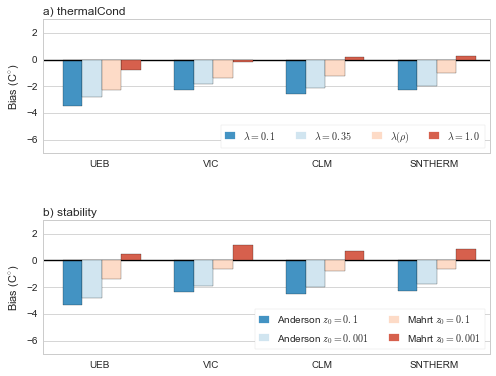

In [57]:
sns.set_context('paper', font_scale=1.25)
alphabet = list(string.ascii_lowercase)
# ----------
# Biases
flag_modelRelative = False
s = 'SWA'
ylims = [-7, 3]

# Bias relative to model with no errors
if flag_modelRelative:
    noBias = results[s].sel(expID='jrdn1991')
    ds = ((results[s].scalarSurfaceTemp) - noBias.scalarSurfaceTemp)
    ds = ds.where((results[s].scalarSWE > 0) & (noBias.scalarSWE > 0))
# Bias relative to observations
else:
    ds = ((results[s].scalarSurfaceTemp - 273.15) - force[s].Tsrf)
    ds = ds.where((force[s].SP) & (results[s].scalarSWE > 0))

# Figure
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 3, hspace=0.5)    
width = 0.175

# ----------
# Met Uncertainty
zorder = [1, 2, 4, 3]
layers = ['layerThin', 'layerThick', 'CLM_2010', 'jrdn1991']
layerLabels = ['UEB', 'VIC', 'CLM', 'SNTHERM']
for n, exp in enumerate(experiments):
    ax = plt.subplot(gs[n, :])
    for layerNum, layer in enumerate(layers):
        for bNum, b in enumerate(sorted(expBias[exp], key=sortFun)):
            expID = layer + '_' + expBias[exp][b]
            xpos = ((bNum + 1) * width) + layerNum
            ax.bar(xpos, np.mean(ds.sel(expID=expID)),
                   width=width, color=sns.color_palette('RdBu_r', 4)[bNum], zorder=zorder[bNum])
    ax.set_ylabel('Bias (C$^{\circ}$)')
    ax.set_xticks(np.arange(0, len(layers) + 1) + 0.5)
    ax.set_xticklabels(layerLabels)
    ax.set_xlim(0, 4)
    ax.xaxis.grid(False)
    ax.plot([0, 6], [0, 0], 'k', zorder=1)
    ax.set_ylim(ylims)
    ax.set_title(alphabet[n] + ') ' + exp.split('_')[1], loc='left')

# ----------
# Custom legends
# Thermal Conductivity
ax = plt.subplot(gs[0, :])
colsche = sns.color_palette('RdBu_r', 4)
groups = ['$\lambda = 0.1$', '$\lambda = 0.35$', r'$\lambda(\rho)$', '$\lambda = 1.0$']
h1 = [matplotlib.patches.Patch(color=colsche[n], label=gr) \
          for n,gr in enumerate(groups)]
leg = ax.legend(handles=h1, loc='lower right', ncol=4, handlelength=1, frameon=True)

# Stability
ax = plt.subplot(gs[1, :])
colsche = sns.color_palette('RdBu_r', 4)
groups = ['Anderson $z_0=0.1$','Anderson $z_0=0.001$','Mahrt $z_0=0.1$','Mahrt $z_0=0.001$']
h1 = [matplotlib.patches.Patch(color=colsche[n], label=gr) \
          for n,gr in enumerate(groups)]
leg = ax.legend(handles=h1, loc='lower right', ncol=2, handlelength=1, frameon=True)

os.chdir(dirPrint)
fig.savefig(s + '.intBias.bias_Ts.bar.pdf')

In [56]:
print(s)

SWA
